# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

34.723484465472737

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.26456726785009

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [209]:
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Alexander\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [236]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [284]:
x = np.random.exponential(size = sample_size)

In [285]:
noise = np.random.uniform(-1,1, size = sample_size)

In [286]:
y = f(x)+noise

In [287]:
from sklearn import tree

In [288]:
reg = tree.DecisionTreeRegressor()
reg.fit(x.reshape(-1,1), y.reshape(-1,1))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [289]:
y_pred = reg.predict(linspace.reshape(-1,1))

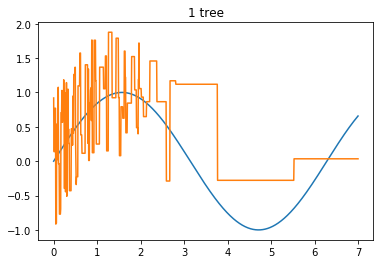

In [290]:
plt.title('1 tree')
plt.plot(linspace, f(linspace))
plt.plot(linspace,y_pred)

График выглядит довльно логично. Так как распределение экспоненциальное, у 0 больше точек и он скачет, описываю шумы. При росте x он уже ведет себя спокойно и неточно:)

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

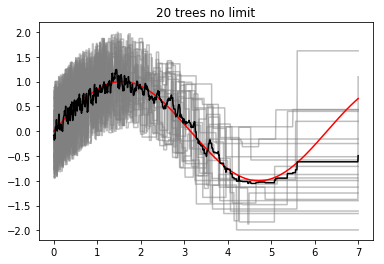

In [291]:
plt.title('20 trees no limit')
y_pred_sum = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size).reshape(-1,1)
    noise = np.random.uniform(-1, 1, sample_size).reshape(-1,1)
    y = f(x) + noise
    reg = tree.DecisionTreeRegressor()
    reg.fit(x, y)
    y_pred = reg.predict(linspace.reshape(-1,1))
    y_pred_sum += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_sum/samples_num
plt.plot(linspace, f(linspace), color = 'red')
plt.plot(linspace, y_pred_mean, color = 'black')


__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

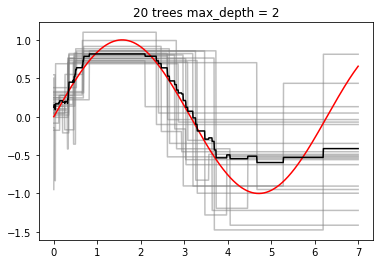

In [292]:
plt.title('20 trees max_depth = 2')
y_pred_sum = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size).reshape(-1,1)
    noise = np.random.uniform(-1, 1, sample_size).reshape(-1,1)
    y = f(x) + noise
    reg = tree.DecisionTreeRegressor(max_depth=2)
    reg.fit(x, y)
    y_pred = reg.predict(linspace.reshape(-1,1))
    y_pred_sum += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_sum/samples_num
plt.plot(linspace, f(linspace), color = 'red')
plt.plot(linspace, y_pred_mean, color = 'black')


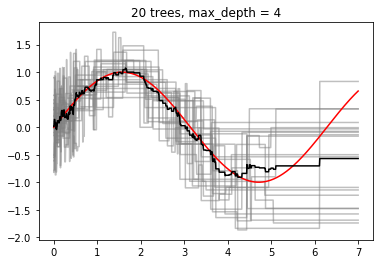

In [293]:
plt.title('20 trees, max_depth = 4')
y_pred_sum = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size).reshape(-1,1)
    noise = np.random.uniform(-1, 1, sample_size).reshape(-1,1)
    y = f(x) + noise
    reg = tree.DecisionTreeRegressor(max_depth=4)
    reg.fit(x, y)
    y_pred = reg.predict(linspace.reshape(-1,1))
    y_pred_sum += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_sum/samples_num
plt.plot(linspace, f(linspace), color = 'red')
plt.plot(linspace, y_pred_mean, color = 'black')


__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Всего были использованы 3 разных гиперпараметра глубины: 'None', 2 и 4. Значение max_depth = 'None' при значении min_samples_split по умолчанию, т.е. = 2, дерево строится до момента, когда в листьях будет просто нечего разбивать (будут объекты только одного класса). Поэтому глубина дерева в этом случае будет больше (ну или как минимум не меньше), чем если на нее наложено ограничение. Четко видно, что разброс растет при увеличении глубины, а смещение наоборот падает. Смещение близко к нулю в случае отсутствия ограничений на глубину. Наибольшее смещение в случае глубины, равной 2. Отметим, что в силу экспоненциального распределения x, дерево лучше работает на объектах около 0, так как дальше оно не всегда успевает упасть до нужного уровня при падении графика и подняться при росте.



__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

In [295]:
from sklearn import linear_model


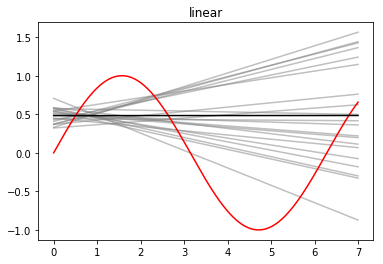

In [299]:
plt.title('linear')
y_pred_sum = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size).reshape(-1,1)
    noise = np.random.uniform(-1, 1, sample_size).reshape(-1,1)
    y = f(x) + noise
    reg = linear_model.LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(linspace.reshape(-1,1))
    y_pred_sum += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_sum/samples_num
plt.plot(linspace, f(linspace), color = 'red')
plt.plot(linspace, y_pred_mean, color = 'black')


In [300]:
from sklearn.svm import SVR

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


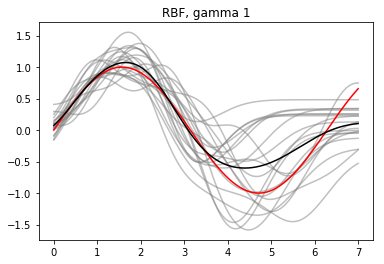

In [301]:
plt.title('RBF, gamma 1')
y_pred_sum = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size).reshape(-1,1)
    noise = np.random.uniform(-1, 1, sample_size).reshape(-1,1)
    y = f(x) + noise
    reg = SVR(kernel='rbf',gamma=1)
    reg.fit(x, y)
    y_pred = reg.predict(linspace.reshape(-1,1))
    y_pred_sum += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_sum/samples_num
plt.plot(linspace, f(linspace), color = 'red')
plt.plot(linspace, y_pred_mean, color = 'black')



C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


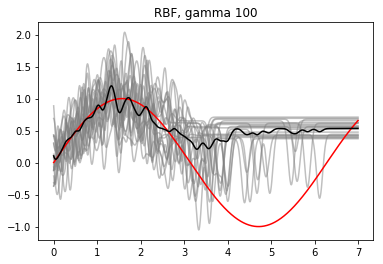

In [302]:
plt.title('RBF, gamma 100')
y_pred_sum = 0
for i in range(samples_num):
    x = np.random.exponential(size = sample_size).reshape(-1,1)
    noise = np.random.uniform(-1, 1, sample_size).reshape(-1,1)
    y = f(x) + noise
    reg = SVR(kernel='rbf',gamma=100)
    reg.fit(x, y)
    y_pred = reg.predict(linspace.reshape(-1,1))
    y_pred_sum += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_sum/samples_num
plt.plot(linspace, f(linspace), color = 'red')
plt.plot(linspace, y_pred_mean, color = 'black')


_Выводы_: 

Удивительно, но линейная регрессия так себе справляется с этой задачей.Горизонтальная линия - не лучшая аппроксимация синуса.

Ядро с гаммой 1 идет плавно, не пытается описывать все шумы, поэтому среднее очень хорошо описывает синус.

Ядро с гаммой 100 пытается захватить все шумы, поэтому его сильно трясет даже на среднем значении, а при росте X появляется и сильно смещение (причем появляется рано).

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [3]:
import pandas as pd

In [374]:
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header = None)
tic_rac = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header = None)
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header = None)

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [6]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

### 1. Mushrooms

Здесь все признаки категориальные, поэтому считаем корректное разбиение и разбиение на все категориальные одинаковым.

In [359]:
y = mushrooms[0]
X = mushrooms.drop(0, 1)

In [360]:
#здесь и далее выбоорки будут перемешаны, так как они вроде как упорядочены
X, y = shuffle(X, y, random_state = 1337)

In [361]:
X_cat = pd.get_dummies(X)

In [362]:
Label_Encoder = LabelEncoder()
y = Label_Encoder.fit_transform(y)


In [363]:
X_num = X.copy()
for i in X_num.columns:
    X_num[i] = Label_Encoder.fit_transform(X_num[i])

In [364]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=np.array(X_num, dtype = 'int'), y = y, cv = 10).mean()

1.0

In [365]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=X_cat, y = y, cv = 10).mean()

1.0

Здесь будут выведены важности признаков в модели, обученной на всей выборке, чтобы в следующем вопросе воспользоваться этими результатами. Аналогично вклады признаков будут выведены далее для других датасетов.

In [366]:
clf = DecisionTreeClassifier()
clf.fit(np.array(X_num, dtype = 'int'), y)
clf.feature_importances_

array([ 0.        ,  0.        ,  0.00297183,  0.02857189,  0.        ,
        0.        ,  0.        ,  0.12000635,  0.34147301,  0.02518618,
        0.04812296,  0.00369754,  0.00194573,  0.01707143,  0.        ,
        0.        ,  0.        ,  0.00131766,  0.00473285,  0.20243024,
        0.17677754,  0.0256948 ])

In [367]:
clf = DecisionTreeClassifier()
clf.fit(X_cat, y)
clf.feature_importances_

array([  0.00000000e+00,   4.91989379e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.96506346e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.45626152e-03,   1.17570796e-02,   0.00000000e+00,
         0.00000000e+00,   1.16088811e-02,   0.00000000e+00,
         6.17099207e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.14471504e-05,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

### 2. Tic-Tac-Toe

Аналогично, здесь все признаки являются категориальными, поэтому праильное разбиение и работа со всеми признаками, как категориальными совпадают.

In [349]:
y = tic_rac[9]
X = tic_rac.drop(9, 1)

In [350]:
X, y = shuffle(X, y, random_state = 1337)

In [351]:
y = Label_Encoder.fit_transform(y)

In [352]:
X_cat = pd.get_dummies(X)

In [353]:
X_num = X.copy()
for i in X_num.columns:
    X_num[i] = Label_Encoder.fit_transform(X_num[i])

In [354]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=np.array(X_num, dtype = 'int'), y = y, cv = 10).mean()

0.88410686833062024

In [355]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=X_cat, y = y, cv = 10).mean()

0.95201550913365907

In [356]:
clf = DecisionTreeClassifier()
clf.fit(np.array(X_num, dtype = 'int'), y)
clf.feature_importances_

array([ 0.08100263,  0.13017909,  0.073051  ,  0.08965108,  0.1209877 ,
        0.11160698,  0.15982045,  0.08843935,  0.14526171])

In [357]:
clf = DecisionTreeClassifier()
clf.fit(X_cat, y)
clf.feature_importances_

array([ 0.0006146 ,  0.08612009,  0.06438191,  0.00642481,  0.0682543 ,
        0.02817231,  0.000439  ,  0.01748261,  0.09090019,  0.01706975,
        0.05228519,  0.04984313,  0.        ,  0.115617  ,  0.        ,
        0.00258132,  0.0708047 ,  0.01133167,  0.00251427,  0.06984844,
        0.01350779,  0.        ,  0.07358297,  0.04700506,  0.00540847,
        0.07988115,  0.02592928])

### 3. Cars

Тут все упорядоченные признаки, поэтому при правильном разбиении я их переведу в вещественные по логичному порядку. А при условии, что все признаки вещественные, будет применен обычный LE.

In [376]:
y = cars[6]
X = cars.drop(6, 1)

In [378]:
X, y = shuffle(X, y, random_state = 1337)

In [379]:
y[y.isin(['acc', 'unacc'])] = 0
y[y.isin(['good', 'vgood'])]= 1

In [380]:
y=list(y.values)

In [381]:
X_correct = X.copy()
X_correct[X_correct == 'low'] = 0
X_correct[X_correct == 'small'] = 0
X_correct[X_correct == 'med'] = 1
X_correct[X_correct == 'high'] = 2
X_correct[X_correct == 'big'] = 2
X_correct[X_correct == 'vhigh'] = 3
X_correct[X_correct == 'more'] = 6
X_correct[X_correct == '5more'] = 6

In [383]:
X_num = X.copy()
for i in X_num.columns:
    X_num[i] = Label_Encoder.fit_transform(X_num[i])

In [384]:
X_cat = pd.get_dummies(X)

In [385]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=np.array(X_num, dtype = 'int'), y = y, cv = 10).mean()

0.9942395081529003

In [386]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X = X_cat, y = y, cv = 10).mean()

0.99016974071103991

In [387]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=np.array(X_correct, dtype = 'int'), y = y, cv = 10).mean()

0.99307671745522585

In [388]:
clf = DecisionTreeClassifier()
clf.fit(np.array(X_num, dtype = 'int'), y)
clf.feature_importances_

array([ 0.37007364,  0.31453538,  0.06016967,  0.11176122,  0.07940458,
        0.06405551])

In [389]:
clf = DecisionTreeClassifier()
clf.fit(np.array(X_correct, dtype = 'int'), y)
clf.feature_importances_

array([ 0.1627184 ,  0.16712392,  0.0405766 ,  0.30229499,  0.13192663,
        0.19535946])

In [390]:
clf = DecisionTreeClassifier()
clf.fit(X_cat, y)
clf.feature_importances_

array([ 0.        ,  0.06622471,  0.02997559,  0.        ,  0.05095601,
        0.05633689,  0.02531883,  0.15475009,  0.04719189,  0.0134834 ,
        0.        ,  0.        ,  0.20329032,  0.00404502,  0.02831514,
        0.02275324,  0.        ,  0.09081631,  0.11246777,  0.09179947,
        0.00227532])

### 4. Nursery

Как сказано в описании данных, все признаки являются ранжированными (так как используются для оценки), поэтому при правильном разбиении, они все будут переведены в численные по логическому принпципу.

In [371]:
y = nursery[8]
X = nursery.drop(8, 1)

In [322]:
X, y = shuffle(X, y, random_state = 1337)

In [323]:
y[y.isin(['not_recom', 'recommend'])] = 0
y[y.isin(['very_recom', 'priority', 'spec_prior'])] = 1

In [324]:
y=list(y.values)

In [325]:
X_num = X.copy()
for i in X_num.columns:
    X_num[i] = Label_Encoder.fit_transform(X_num[i])

In [326]:
X_cat = pd.get_dummies(X)

In [327]:
X_correct = X.copy()
#parents
X_correct[0][X_correct[0] == 'usual'] = 0
X_correct[0][X_correct[0] == 'pretentious'] = 1
X_correct[0][X_correct[0] == 'great_pret'] = 2
#has_nurs
X_correct[1][X_correct[1] == 'very_crit'] = 0
X_correct[1][X_correct[1] == 'critical'] = 1
X_correct[1][X_correct[1] == 'improper'] = 2
X_correct[1][X_correct[1] == 'less_proper'] = 3
X_correct[1][X_correct[1] == 'proper'] = 4
#form
X_correct[2][X_correct[2] == 'complete'] = 0
X_correct[2][X_correct[2] == 'completed'] = 1
X_correct[2][X_correct[2] == 'incomplete'] = 2
X_correct[2][X_correct[2] == 'foster'] = 3
#children
X_correct[3][X_correct[3] == 'more'] = 5
#housing
X_correct[4][X_correct[4] == 'critical'] = 0
X_correct[4][X_correct[4] == 'less_conv'] = 1
X_correct[4][X_correct[4] == 'convenient'] = 2
#finance
X_correct[5][X_correct[5] == 'inconv'] = 0
X_correct[5][X_correct[5] == 'convenient'] = 1
#social
X_correct[6][X_correct[6] == 'problematic'] = 0
X_correct[6][X_correct[6] == 'slightly_prob'] = 1
X_correct[6][X_correct[6] == 'nonprob'] = 2
#health
X_correct[7][X_correct[7] == 'not_recom'] = 0
X_correct[7][X_correct[7] == 'recommended'] = 1
X_correct[7][X_correct[7] == 'priority'] = 2

In [328]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=np.array(X_num, dtype = 'int'), y = y, cv = 10).mean()

0.99976839935173278

In [329]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=X_cat, y = y, cv = 10).mean()

0.99961407836407845

In [330]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=np.array(X_correct, dtype = 'int'), y = y, cv = 10).mean()

0.99969129844129845

In [333]:
clf = DecisionTreeClassifier()
clf.fit(np.array(X_num, dtype = 'int'), y)
clf.feature_importances_

array([  5.14284300e-06,   9.25711740e-05,   4.82141531e-07,
         1.92856613e-06,   1.54285290e-05,   1.15713968e-04,
         2.31427935e-04,   9.99537305e-01])

In [332]:
clf = DecisionTreeClassifier()
clf.fit(X_cat, y)
clf.feature_importances_

array([  0.00000000e+00,   0.00000000e+00,   2.57142150e-05,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.42855375e-07,   0.00000000e+00,   9.64283063e-06,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.41070766e-06,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   7.71426450e-05,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.31427935e-04,
         0.00000000e+00,   2.31427935e-04,   0.00000000e+00,
         9.99305877e-01,   0.00000000e+00,   1.15713968e-04])

In [334]:
clf = DecisionTreeClassifier()
clf.fit(np.array(X_correct, dtype = 'int'), y)
clf.feature_importances_

array([  7.71426450e-05,   6.42855375e-07,   9.64283063e-06,
         2.41070766e-06,   2.57142150e-05,   1.15713968e-04,
         2.31427935e-04,   9.99537305e-01])

In [273]:
cv = ShuffleSplit(n_splits= 10, test_size=0.3, random_state=42)

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

_Анализ результатов_:

На 1 датасете оба алгоритма добиваются максимально точности (все классифицируется верно). Вероятно, результат хорошо описывается некоторыми определенными значениями признаков, иначе я не могу объяснить как при LabelEncoding получается максимальная точность.

На 2 датасете получается очень логичный результат, категориальные признаки работают лучше, чем численные, однако, стоит отметить, что LabelEncoder оже работает неплохо, что можно объяснить тем, что признаки однородны и дерево может подсроиться под значения в квадратах, заданные в численном виде.

На 3 датасете получается довольно странный результат: все методы работают хорошо, но лучше всего работает именно LabelEncoder. Скорее всего, в этом есть какой-то элемент случайности. Разбиение на категориальные, скорее всего, работает чуть хуже из-за большого количества признаков. 

На 4 датасете результат и интерпретация аналогичны 3му.
Однако, то что на двух датасетах LE обыгал авторское правильное разбиение наводит на мысль, что я зря тратил время и менял вруную признаки.

Стоит отметить, что разница в точности и в 3 и в 4 датасете очень маленькая. То есть возможно есть какие-то выбросы, которые не цепляют алгоритмы и так вот выходит, что LE случайно описывает что-то лучше. Но при этом все разбиения приводят к весьма высокой точности на этих данных.

_О значении признаков, случайностях и влиянии на них_:

Первые 2 датасета, наверно, не особо представляют интереса для этого вопроса. В 1м просто все точно предсказывается, причем на разных шафлах, поэтому элемента случайности тут нет. Работу алгоритмов, улучшать довольно бесперспективная работа. Несколько признаков получаются значимыми и описывают весь результат. Во 2м датасете весьма специфические признаки: клетки поля, в которых показано, что в них стоит. Думаю, тут тоже мало элемента случайности, так как, во-первых, признаки имеют одинаковые значения, а во-вторых, это игра с определенными правилами. Значимость признаков примерно одинаковая для обоих разбиений.

Все немного сложнее с 3 и 4 датасетами. В 3м признаки довольно простые и с ними врое все прозрачно, однако LE работает лучше правильного разбиения. Причем по вкладу в модель признаки в этих двух разбиениях не совпадают. Возможно, если бы на кросс-валидации трэйновая выборка была б поменьше, а тестовая больше, что-то бы поменялось.  

В 4х данных все оказалось довольно просто: в обоих случаях есть наиболее важный признак - последний, который имеет наибольший вклад в модель. Открыв данные, я увидел что этот столбец почти совпадает с ответами!   



In [395]:
nursery.head()

,0,1,2,3,4,5,6,7,8
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [127]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [203]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ';')
y = df['quality']
X = df.drop('quality', 1)

In [124]:
X, y = shuffle(X, y, random_state = 1337)

In [125]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X = X, y = y, cv = 3).mean()

0.60480079429054245

In [128]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score), X = X, y = y, cv = 3).mean()

0.67417753869017805

In [129]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100, max_features = 0.5), scoring = make_scorer(accuracy_score), X = X, y = y, cv = 3).mean()

0.67791128629584307

In [130]:
cross_val_score(estimator = RandomForestClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score), X = X, y = y, cv = 3).mean()

0.69725157460260789

Действительно возрастает!

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [216]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [204]:
X, y = shuffle(X, y, random_state = 1337)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1337)

In [279]:
clf = RandomForestClassifier(n_estimators = 100,  warm_start = True, random_state = 1337)

In [280]:
score = []
score_train = []
x_axis = []
a = 0
for i in range(50):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score.append(accuracy_score(y_test, y_pred))
    y_train_pred = clf.predict(X_train)
    score_train.append(accuracy_score(y_train, y_train_pred))
    a += 100
    x_axis.append(a)
    clf.set_params(n_estimators = a)

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


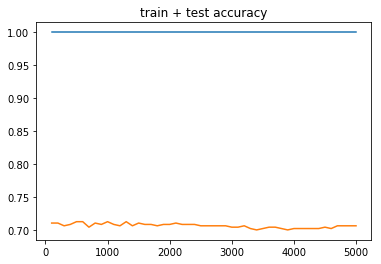

In [303]:
plt.title('train + test accuracy')
plt.plot(x_axis, score_train)
plt.plot(x_axis, score)

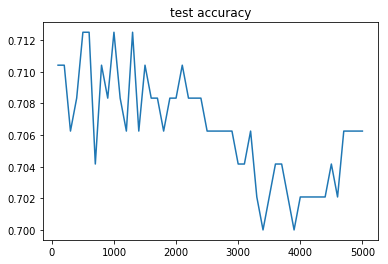

In [304]:
plt.title('test accuracy')
plt.plot(x_axis, score)

Результат с ростом числа деревьев немного падает, но падение совсем незначительное (около 0.01), а в конце даже немного подрастает. На обучающей выборке результат стабильно 1. Поэтому о переобучении в явном виде говорить трудно.  

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [58]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [73]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils

Для решения частично (или не очень) использовался код отсюда, скрипт предоставлен разработчиками кераса (вроде как):

https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

In [23]:
plt.rcParams['figure.figsize'] = (7,7)

In [87]:
x_train.shape

(60000, 28, 28)

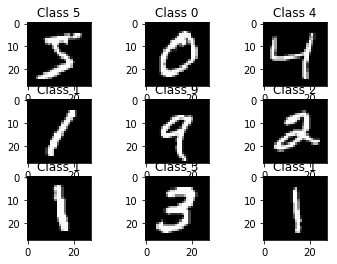

In [8]:
#посмотриим, что же лежит в данных.
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

In [59]:
#приведем данные в рабочий для сети формат, отшкалируем их от 0 до 1
X_train = x_train.reshape(60000, 784)
X_test = x_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [60]:
#переведем ответы в дамми формат
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [32]:
Y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [33]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [16]:
from keras.optimizers import Adadelta
from keras.losses import categorical_crossentropy

In [17]:
#сделаем сеть
model = Sequential()

model = Sequential()
model.add(Dense(512, input_shape=(784,), activation = 'relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

In [61]:
model.fit(x=X_train, y=Y_train, batch_size=128, epochs = 10, verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 169us/step - loss: 0.6613 - acc: 0.9571 - val_loss: 0.6436 - val_acc: 0.9588
Epoch 2/10
60000/60000 [==============================] - 10s 174us/step - loss: 0.5930 - acc: 0.9615 - val_loss: 0.5990 - val_acc: 0.9613
Epoch 3/10
60000/60000 [==============================] - 11s 178us/step - loss: 0.5726 - acc: 0.9629 - val_loss: 0.6047 - val_acc: 0.9611
Epoch 4/10
60000/60000 [==============================] - 10s 163us/step - loss: 0.5513 - acc: 0.9641 - val_loss: 0.5940 - val_acc: 0.9619
Epoch 5/10
60000/60000 [==============================] - 10s 166us/step - loss: 0.5369 - acc: 0.9652 - val_loss: 0.5823 - val_acc: 0.9626
Epoch 6/10
60000/60000 [==============================] - 11s 182us/step - loss: 0.5152 - acc: 0.9666 - val_loss: 0.5708 - val_acc: 0.9632
Epoch 7/10
60000/60000 [==============================] - 10s 172us/step - loss: 0.5013 - acc: 0.9677 - val_loss: 0.

In [62]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9643


Пока давать какую-то интерпретацию точности трудно, но выглядит довольно большой!

In [63]:
predicted_classes = model.predict_classes(X_test)

correct_indices = np.nonzero(predicted_classes == y_test)
incorrect_indices = np.nonzero(predicted_classes != y_test)

In [64]:
predicted_classes

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

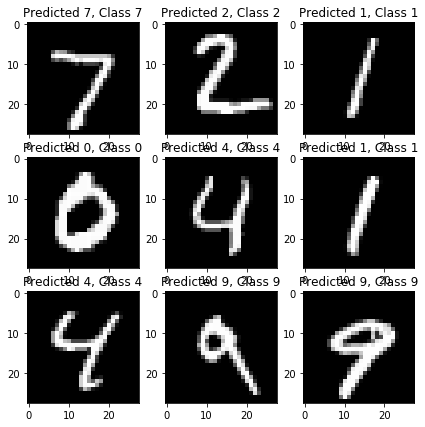

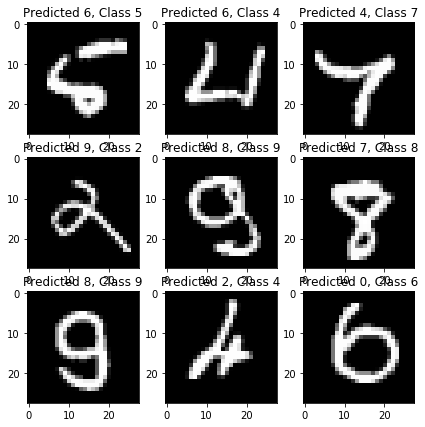

In [65]:
#немного посмотрим на то, какие цифры классифицируются верно, а какие - нет
plt.figure()
for i, correct in enumerate(correct_indices[0][:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[0][:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

Стоит признать, что ошибки выглядят весьма логично, предсказания реально похожи на то, на коряво написанные неправильные цифры.

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [77]:
from keras import backend

In [89]:
#тоже приведем данные в рабочий формат
if backend.image_data_format() == 'channels_first':
    X_train2 = x_train.reshape(x_train.shape[0], 1, 28, 28)
    X_test2 = x_test.reshape(x_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train2 = x_train.reshape(x_train.shape[0], 28, 28, 1)
    X_test2 = x_test.reshape(x_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

X_train2 = X_train2.astype('float32')
X_test2 = X_test2.astype('float32')
X_train2 /= 255
X_test2 /= 255

In [92]:
#собираем слои
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [93]:
model.fit(x=X_train2, y=Y_train, batch_size=128, epochs = 10, verbose=1,
          validation_data=(X_test2, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 248s 4ms/step - loss: 0.1658 - acc: 0.9491 - val_loss: 0.0688 - val_acc: 0.9763
Epoch 2/10
60000/60000 [==============================] - 244s 4ms/step - loss: 0.0442 - acc: 0.9869 - val_loss: 0.0388 - val_acc: 0.9875
Epoch 3/10
60000/60000 [==============================] - 250s 4ms/step - loss: 0.0272 - acc: 0.9916 - val_loss: 0.0409 - val_acc: 0.9877
Epoch 4/10
60000/60000 [==============================] - 245s 4ms/step - loss: 0.0182 - acc: 0.9944 - val_loss: 0.0377 - val_acc: 0.9894
Epoch 5/10
60000/60000 [==============================] - 246s 4ms/step - loss: 0.0124 - acc: 0.9962 - val_loss: 0.0433 - val_acc: 0.9886
Epoch 6/10
60000/60000 [==============================] - 252s 4ms/step - loss: 0.0087 - acc: 0.9972 - val_loss: 0.0395 - val_acc: 0.9897
Epoch 7/10
60000/60000 [==============================] - 254s 4ms/step - loss: 0.0056 - acc: 0.9983 - val_loss: 0.0459 - 

In [94]:
score = model.evaluate(X_test2, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9904


Ура!

In [95]:
predicted_classes = model.predict_classes(X_test2)

correct_indices = np.nonzero(predicted_classes == y_test)
incorrect_indices = np.nonzero(predicted_classes != y_test)

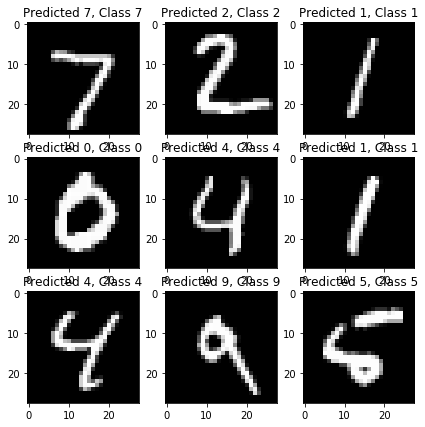

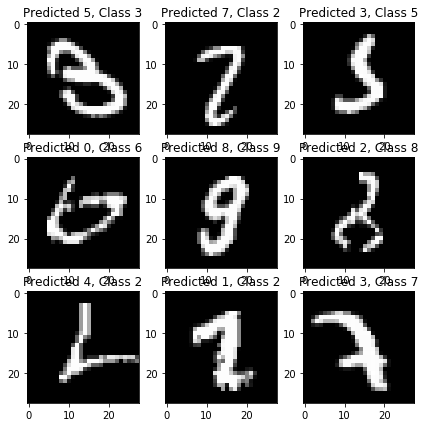

In [96]:
#тоже посмотрим на работу алгоритма на реальных цифрах
plt.figure()
for i, correct in enumerate(correct_indices[0][:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[0][:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

Прошу обратить внимание на то, что усложненная сетка правильно классифицировала загогулину в правом нижнем углу, а первая сеть с этим не справилась.

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [97]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
model.fit(x=X_train2, y=Y_train, batch_size=128, epochs = 10, verbose=1,
          validation_data=(X_test2, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 259s 4ms/step - loss: 0.2452 - acc: 0.9254 - val_loss: 0.0558 - val_acc: 0.9820
Epoch 2/10
60000/60000 [==============================] - 256s 4ms/step - loss: 0.0946 - acc: 0.9726 - val_loss: 0.0512 - val_acc: 0.9846
Epoch 3/10
60000/60000 [==============================] - 256s 4ms/step - loss: 0.0749 - acc: 0.9789 - val_loss: 0.0457 - val_acc: 0.9857
Epoch 4/10
60000/60000 [==============================] - 257s 4ms/step - loss: 0.0634 - acc: 0.9816 - val_loss: 0.0390 - val_acc: 0.9875
Epoch 5/10
60000/60000 [==============================] - 256s 4ms/step - loss: 0.0585 - acc: 0.9831 - val_loss: 0.0369 - val_acc: 0.9877
Epoch 6/10
60000/60000 [==============================] - 257s 4ms/step - loss: 0.0519 - acc: 0.9849 - val_loss: 0.0361 - val_acc: 0.9884
Epoch 7/10
60000/60000 [==============================] - 256s 4ms/step - loss: 0.0508 - acc: 0.9852 - val_loss: 0.0393 - 

Точность на тестовой выборке падает немного и заметно на трэйновой, процесс обучения немного замедляется. Это логично, так как dropout борется с переобучением.